# Learned Reconstruction

In inverse problems, we want to recover some signal $x$ from noisy measurements $y$ where we know the forward model $\mathcal{T} : \mathcal{X} \to \mathcal{Y}$
$$
    y = \mathcal{T}(x) + e
$$
In machine learning for inverse problems we aim to find some operator $\mathcal{T}_\theta^\dagger : \mathcal{Y} \to \mathcal{X}$ that inverts this process
$$
    \mathcal{T}_\theta^\dagger(y) \approx x
$$

This notebook demonstrates how to use ODL to perform learned reconstruction of the famous MNIST dataset. We demonstrate three ways of doing this

* Fully learned reconstruction
* Learned post-processing
* Learned iterative reconstruction

and we also compare to FBP-based reconstruction.

The results should be approximately

| Method                 |  Mean Error  |
|------------------------|----------|
| FBP                    | 0.01694  |
| Fully learned          | 0.00226  |
| FBP + learned denoiser | 0.00260  |
| Learned Iterative      | 0.005150 |

Note that the examples in this notebook may take some time to run, approximately 10-15 minutes each can be expected on a reasonable laptop.

**Note:** This is a pytorch port of [the notebook using tensorflow](part3_learned_reconstruction.ipynb) with reduced text, see the other notebook for more details.

In [1]:
% matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import odl
from odl.contrib.torch import OperatorAsModule
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import datasets, transforms
torch.manual_seed(123);  # reproducibility

/home/hkohr/git/odl/odl/trafos/backends/pyfftw_bindings.py:30: RuntimeWarning: PyFFTW < 0.10.4 is known to cause problems with some ODL functionality, see issue #1002.
  RuntimeWarning)


## Get training and test data

We create loaders for the MNIST data:

In [2]:
# Load training and test data (from the official MNIST example,
# https://github.com/pytorch/examples/blob/master/mnist/main.py)
trafo = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
dset_train = datasets.MNIST('./data', train=True, download=True, transform=trafo)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=50, shuffle=True)

dset_test = datasets.MNIST('./data', train=False, transform=trafo)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=50, shuffle=True)

## Create ODL objects

We initialize the ray transform on a space suitable for the MNIST images. We also create a filtered backprojection (FBP) operator for comparison, and for the FBP denoising net later on:

In [3]:
space = odl.uniform_discr([-14, -14], [14, 14], [28, 28], dtype='float32')
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=5)
fwd_op = odl.tomo.RayTransform(space, geometry)
fbp_op = odl.tomo.fbp_op(fwd_op)

## Make pytorch `Module`s from ODL operators

For use in our neural networks, we create pytorch modules from the above operators. For this we use the `OperatorAsModule` class from `odl.contrib.torch`. It implements automatic differentiation as required for backpropagation in pytorch, and it supports extra batch and channel axes.

In [4]:
fwd_op_mod = OperatorAsModule(fwd_op)
fwd_op_adj_mod = OperatorAsModule(fwd_op.adjoint)
fbp_op_mod = OperatorAsModule(fbp_op)

## Some helper functions

For the generation of noisy projection data and for visualization of the results we use the following helpers:

In [5]:
def generate_data(images):
    """Create noisy projection data from images.
    
    The data is generated according to ::
        
        data = fwd_op(images) + noise
        
    where ``noise`` is standard white noise.
    
    Parameters
    ----------
    images : `Variable`, shape ``(B, C, 28, 28)``
        Input images for the data generation.
        
    Returns
    -------
    data : `Variable`, shape ``(B, C, 5, 41)``
        Projection data stack.
    """
    torch.manual_seed(123)
    data = fwd_op_mod(images)
    data += Variable(torch.randn(data.shape)).type_as(data)
    return data


def show_image_matrix(image_batches, titles=None, indices=None, **kwargs):
    """Visualize a 2D set of images arranged in a grid.

    This function shows a 2D grid of images, where the i-th column
    shows images from the i-th batch. The typical use case is to compare
    results of different approaches with the same data, or to compare
    against a ground truth.

    Parameters
    ----------
    image_batches : sequence of `Tensor` or `Variable`
        List containing batches of images that should be displayed.
        Each tensor should have the same shape after squeezing, except
        for the batch axis.
    titles : sequence of str, optional
        Titles for the colums in the plot. By default, titles are empty.
    indices : sequence of int, optional
        Object to select the subset of the images that should be shown.
        The subsets are determined by slicing along the batch axis, i.e.,
        as ``displayed = image_batch[indices]``. The default is to show
        everything.
    kwargs :
        Further keyword arguments that are passed on to the Matplotlib
        ``imshow`` function.
    """
    import matplotlib.pyplot as plt

    if indices is None:
        displayed_batches = image_batches
    else:
        displayed_batches = [batch[indices] for batch in image_batches]

    displayed_batches = [batch.data if isinstance(batch, Variable) else batch
                         for batch in displayed_batches]

    nrows = len(displayed_batches[0])
    ncols = len(displayed_batches)

    if titles is None:
        titles = [''] * ncols

    figsize = 2
    fig, rows = plt.subplots(
        nrows, ncols, sharex=True, sharey=True,
        figsize=(ncols * figsize, figsize * nrows))

    if nrows == 1:
        rows = [rows]

    for i, row in enumerate(rows):
        if ncols == 1:
            row = [row]
        for name, batch, ax in zip(titles, displayed_batches, row):
            if i == 0:
                ax.set_title(name)
            ax.imshow(batch[i].squeeze(), **kwargs)
            ax.set_axis_off()
    plt.show()

## Generate test data

We take one batch from the test dataset and generate the corresponding test projection data for validation:

In [6]:
# Get a batch of test images and generate test projection data
for i, (images, _) in enumerate(test_loader):
    if i == 1:
        break

test_images = Variable(images)
test_data = generate_data(test_images)

## FBP reconstruction

First we make a simple FBP reconstruction and compare it to the ground truth.

Average error: 0.01694210171699524


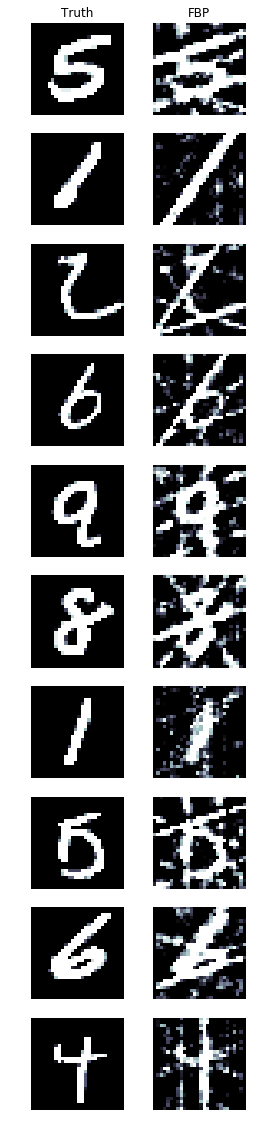

In [7]:
fbp_recos = fbp_op_mod(test_data)
print('Average error:', F.mse_loss(fbp_recos, test_images).data[0] / len(test_images))

# Display examples
results = [test_images, fbp_recos]
titles = ['Truth', 'FBP']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')

## Fully learned reconstruction

Now for the first neural network that learns how to reconstruct. We use a rather simple approach of fully connected layers at each level, gradually proceeding from size `5 * 41` to size `28 * 28`:

In [8]:
class FullRecoNet(nn.Module):
    def __init__(self):
        super(FullRecoNet, self).__init__()
        self.lin1 = nn.Linear(5 * 41, 1024)
        self.lin2 = nn.Linear(1024, 1024)
        self.lin3 = nn.Linear(1024, 28 ** 2)

    def forward(self, x):
        x = F.relu(self.lin1(x.view(-1, 5 * 41)))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x.view(-1, 1, 28, 28)

Let's train the network and see how well it does. We run 1 epoch for each model to have a somewhat fair comparison.

In [9]:
# Use these parameters to steer the training
use_cuda = True
learning_rate = 1e-3
log_interval = 20
epochs = 1
full_net = FullRecoNet()
loss_train = nn.MSELoss()
loss_test = nn.MSELoss()

if use_cuda:
    full_net = full_net.cuda()
    test_data = test_data.cuda()
    test_images = test_images.cuda()

optimizer = optim.Adam(full_net.parameters(), lr=learning_rate)


def train(epoch):
    full_net.train()
    for batch_idx, (images, _) in enumerate(train_loader):
        if use_cuda:
            images = images.cuda()
        images = Variable(images)
        projs = generate_data(images)

        optimizer.zero_grad()
        output = full_net(projs)
        loss = loss_train(output, images)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'
                  ''.format(epoch, batch_idx * len(images),
                            len(train_loader.dataset),
                            100. * batch_idx / len(train_loader),
                            loss.data[0]))


def test():
    full_net.eval()
    loss = loss_test(full_net(test_data), test_images) / len(test_images)
    print('\nTest set: Average loss: {:.6f}'.format(loss.data[0]))


for epoch in range(1, epochs + 1):
    train(epoch)
    clear_output()
    test()


Test set: Average loss: 0.002258


Visualizing a sample from the results in comparison to FBP:

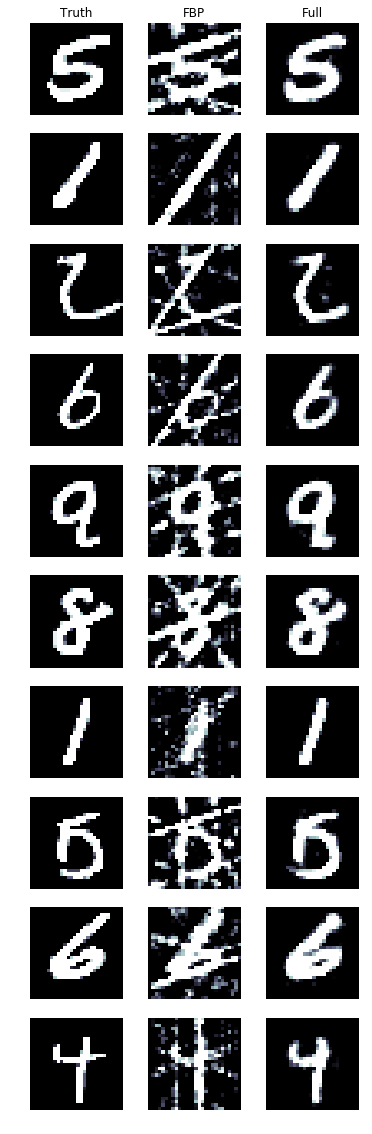

In [10]:
test_res_full = full_net(test_data)
results = [test_images, fbp_recos, test_res_full]
titles = ['Truth', 'FBP', 'Full']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')

These examples look much better than FBP (unsurprisingly), but there are still some issues with noise, deformations etc.

To also make an assessment about the number of trainable parameters and thus the scalability of the approach (the more parameters, the harder to train), the total number of parameters in the model can be checked like this:

In [11]:
print('Total number of parameters:',
      sum(param.numel() for param in full_net.parameters()))
print('Training data size:', 60000 * 28 ** 2)

Total number of parameters: 2064144
Training data size: 47040000


It turns out that for this tiny problem, the number of parameters is over 2 million. This is still a good deal away from the input data size (47 million), but overfitting is likely with this network. Therefore we explore sparser architectures.

## FBP denoising net

This network operates entirely on the 28 x 28 sized image domain by taking an FBP reconstruction as input and then trying to learn how to remove the noise and the streak artefacts. It uses convolutions that have far fewer parameters.

In [12]:
class DenoisingNet(nn.Module):
    def __init__(self):
        super(DenoisingNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

Let's train this network and see what we get. Note that in the training loop, we now have to use `fbp_op_mod(projs)` instead of `projs`:

In [13]:
use_cuda = True
learning_rate = 1e-3
log_interval = 20
epochs = 1
denoise_net = DenoisingNet()
loss_train = nn.MSELoss()
loss_test = nn.MSELoss()

if use_cuda:
    denoise_net = denoise_net.cuda()
    test_data = test_data.cuda()
    test_images = test_images.cuda()

optimizer = optim.Adam(denoise_net.parameters(), lr=learning_rate)


def train(epoch):
    denoise_net.train()
    for batch_idx, (images, _) in enumerate(train_loader):
        if use_cuda:
            images = images.cuda()
        images = Variable(images)
        projs = generate_data(images)
        fbp_recos = fbp_op_mod(projs)

        optimizer.zero_grad()
        output = denoise_net(fbp_recos)
        loss = loss_train(output, images)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'
                  ''.format(epoch, batch_idx * len(images),
                            len(train_loader.dataset),
                            100. * batch_idx / len(train_loader),
                            loss.data[0]))


def test():
    denoise_net.eval()
    loss = (loss_test(denoise_net(fbp_op_mod(test_data)), test_images) /
            len(test_images))
    print('\nTest set: Average loss: {:.6f}'.format(loss.data[0]))


for epoch in range(1, epochs + 1):
    train(epoch)
    clear_output()
    test()


Test set: Average loss: 0.002601


Again we visualize the results and compare them to the earlier ones:

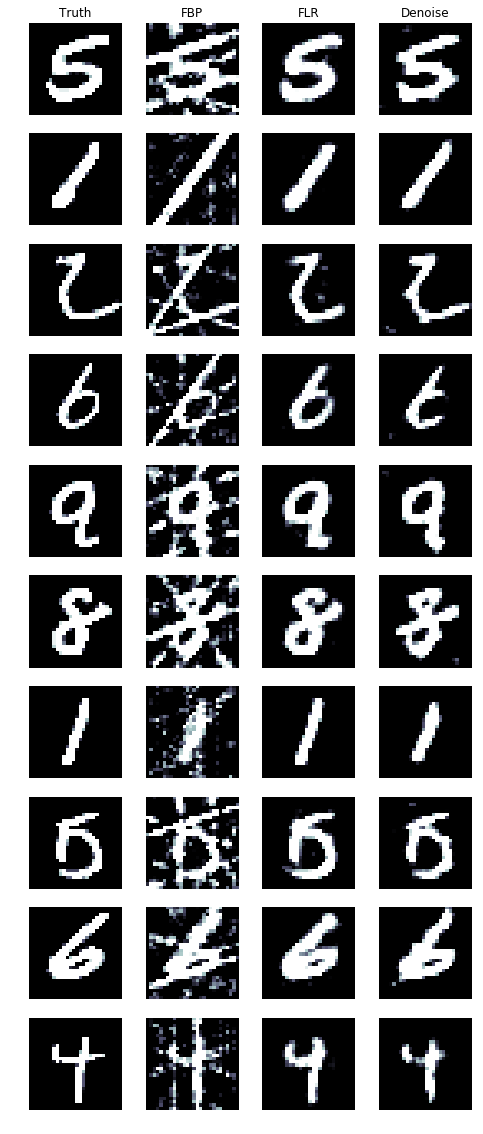

In [14]:
test_res_denoise = denoise_net(fbp_op_mod(test_data))
results = [test_images, fbp_recos, test_res_full, test_res_denoise]
titles = ['Truth', 'FBP', 'FLR', 'Denoise']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')

The images look as if denoising was effective, but there are issues with streaks not being removed and instead taken as mage features.

For comparsion we check how many parameters this model has:

In [15]:
print('Total number of parameters:',
      sum(param.numel() for param in denoise_net.parameters()))

Total number of parameters: 9857


This model has less than 10000 parameters and thus better chances to scale well.

## Iterative net

The last variant uses an unrolled iterative loop with a learned gradient update as its network architecture. Thus, the network tries to get the best reconstruction out of a budget of iterations, but learning how to best update the current guess given the gradient of the $L^2$ data fit.

Since we use only 2 iterations here, it is very important to already start from a decent estimate. We later use the FBP reconstruction as start of the iterative loop.

In [16]:
class IterativeNet(nn.Module):
    def __init__(self, niter, op, op_adj, init_op=None):
        super(IterativeNet, self).__init__()
        self.niter = niter
        self.op = op
        self.op_adj = op_adj
        self.init_op = init_op

        # Make iterative blocks
        for it in range(niter):
            block = []
            block.append(nn.Conv2d(2, 32, 3, padding=1))
            block.append(nn.Conv2d(32, 32, 3, padding=1))
            block.append(nn.Conv2d(32, 1, 3, padding=1))
            mod_block = nn.ModuleList(block)
            setattr(self, 'mod_block_iter_{}'.format(it), mod_block)

    def forward(self, y):
        if self.init_op is None:
            # Effectively start from zero (not counting to iterations)
            cur = self.op_adj(y)
        else:
            cur = self.init_op(y)

        for it in range(self.niter):

            # Get block of modules for dx
            mod_block = getattr(self, 'mod_block_iter_{}'.format(it))

            # Set gradient of ||A(x) - y||^2
            grad = self.op_adj(self.op(cur) - y)

            # Combine the two with learable parameters
            dx = torch.cat([cur, grad], dim=1)
            for i, mod in enumerate(mod_block):
                dx = mod(dx)
                if i < len(mod_block) - 1:
                    dx = F.relu(dx)

            # Iteration update
            cur = cur + dx

        return cur

Let's train this one, too. It will take significantly longer since it is deeper and requires more computation in each forward and backward pass:

In [17]:
use_cuda = True
learning_rate = 1e-3
log_interval = 20
epochs = 1
iter_net = IterativeNet(niter=2, op=fwd_op_mod, op_adj=fwd_op_adj_mod,
                        init_op=fbp_op_mod)
loss_train = nn.MSELoss()
loss_test = nn.MSELoss()

if use_cuda:
    iter_net = iter_net.cuda()
    test_data = test_data.cuda()
    test_images = test_images.cuda()

optimizer = optim.Adam(iter_net.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.1)


def train(epoch):
    iter_net.train()
    for batch_idx, (images, _) in enumerate(train_loader):
        if use_cuda:
            images = images.cuda()
        images = Variable(images)
        projs = generate_data(images)

        optimizer.zero_grad()
        output = iter_net(projs)
        loss = loss_train(output, images)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'
                  ''.format(epoch, batch_idx * len(images),
                            len(train_loader.dataset),
                            100. * batch_idx / len(train_loader),
                            loss.data[0]))


def test():
    iter_net.eval()
    loss = loss_test(iter_net(test_data), test_images) / len(test_images)
    print('\nTest set: Average loss: {:.6f}'.format(loss.data[0]))


for epoch in range(1, epochs + 1):
    train(epoch)
    clear_output()
    test()


Test set: Average loss: 0.005150


Comparing the result with earlier network architectures:

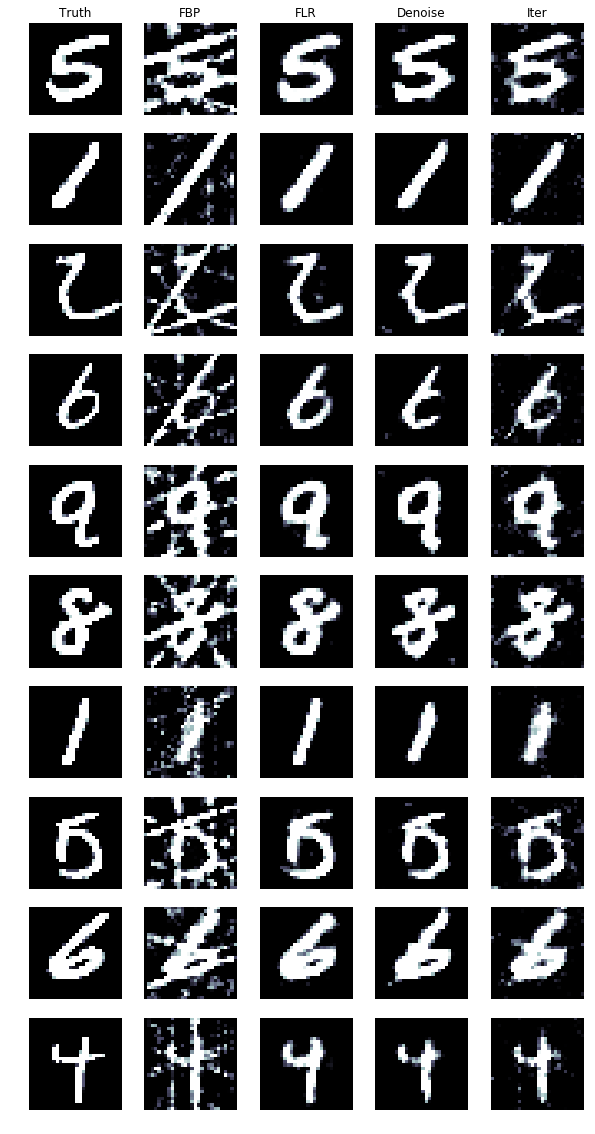

In [19]:
test_res_iter = iter_net(test_data)
results = [test_images, fbp_recos, test_res_full, test_res_denoise, test_res_iter]
titles = ['Truth', 'FBP', 'FLR', 'Denoise', 'Iter']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')

The results are a bit mixed, and the value of the loss function seems to be at a higher level than for the others. Presumably, this model would need more training.

How many learnable parameters do we have now?

In [20]:
print('Total number of parameters:',
      sum(p.numel() for p in iter_net.parameters()))

Total number of parameters: 20290
